In [1]:
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 핸즈온 머신러닝 2판

# Chater 4 모델 훈련

## 4.1 선형 회귀

### 4.1.1 정규방정식

#### 선형처럼 보이는 데이터 생성

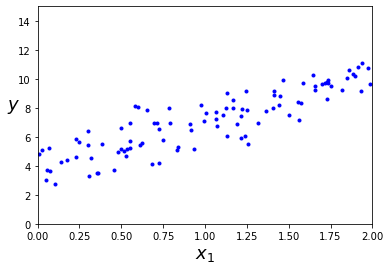

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

정규방정식 사용

In [3]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.8367272 ],
       [3.22658376]])

$\hat{\theta} $를 사용해 예측하기

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.8367272 ],
       [10.28989472]])

시각화

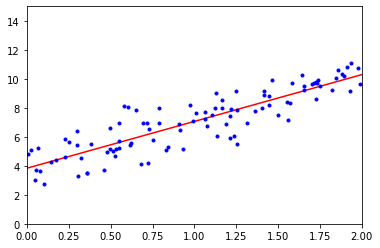

In [5]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

사이킷런에서 선형 회귀 수행

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[3.8367272] [[3.22658376]]
[[ 3.8367272 ]
 [10.28989472]]


In [7]:
#LinearRegression 클래스는 scipy.linalg.lstsq() 함수("least squares"의 약자)를 사용
theta_best_svd, residuals, rank, s =np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.8367272 ],
       [3.22658376]])

In [8]:
# np.linalg.pinv() 함수를 사용해 유사역행렬을 직접 구할 수 있다.
np.linalg.pinv(X_b).dot(y)

array([[3.8367272 ],
       [3.22658376]])

## 4.2 경사하강법

### 4.2.1 배치 경사 하강법

경사하강법 구현

In [9]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[3.8367272 ],
       [3.22658376]])

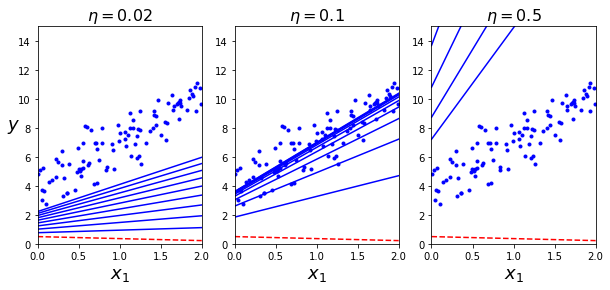

In [10]:
#여러가지 학습률에 대한 경사 하강법
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    
    
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()
#반복 횟수를 아주 크게 지정하고 gradient 벡터가 허용오차보다 작아지면 경사하강법 알고리즘을 중지


### 4.2.2 확률적 경사 하강법

확률적 경사 하강법 구현

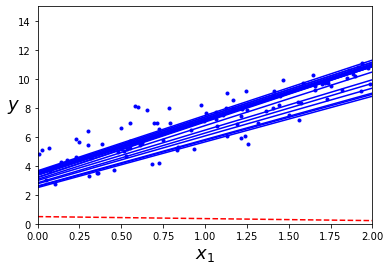

In [11]:
#학습 스케쥴을 사용한 확률적 경사 하강법
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 =5, 50

def learning_schedule(t):
    return t0 / (t + t1)
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--" 
            plt.plot(X_new, y_predict, style) 
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index +1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
plt.plot(X, y, "b.")                            
plt.xlabel("$x_1$", fontsize=18)                    
plt.ylabel("$y$", rotation=0, fontsize=18)         
plt.axis([0, 2, 0, 15])                             
plt.show()                                   

사이킷 런에서의 선형 회귀

In [12]:
#  sklearn의 SGDRegressor 클래스를 사용
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[3.85971128] [3.27263925]


### 4.2.3 미니배치 경사 하강법

미니배치 경사 하강법 구현

In [13]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
theta

array([[3.94086897],
       [3.33201009]])

## 4.3 다항 회귀

2차 방정식으로 비선형 데이터 생성하기

In [14]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

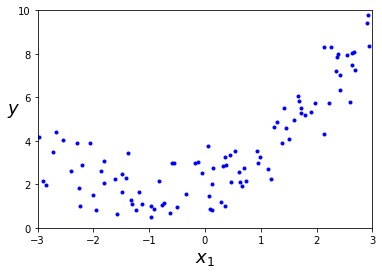

In [15]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [16]:
#사이킷런의 PolynomialFeatures() : 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([2.38942838]), array([2.38942838, 5.709368  ]))

In [17]:
#확장된 훈련 데이터에 LinearRegression을 적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

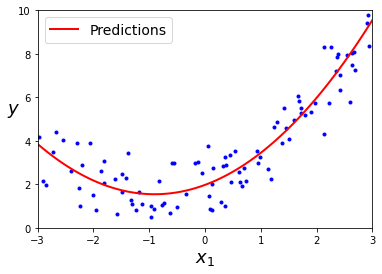

In [18]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

## 4.4 학습 곡선

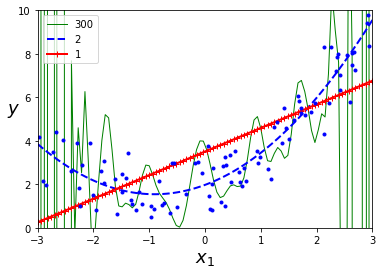

In [19]:
#300차 다항 회귀
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

모델의 학습 곡선을 그리는 함수

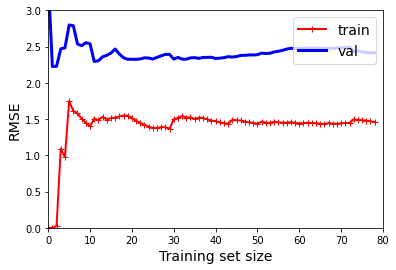

In [20]:
#모델의 일반화 성능을 추정하기 위해 학습 곡선을 살펴보기도 한다.
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)             
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                      
plt.show()
#과소적합 모델의 전형적인 모습

10차 다항 회귀 모델의 학습 곡선

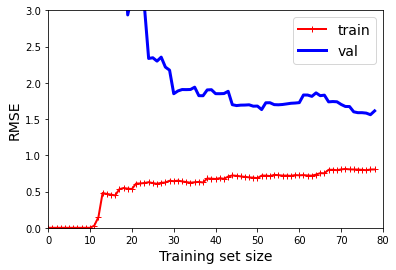

In [21]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])          
plt.show()                    

## 4.5 규제가 있는 선형 모델

### 4.5.1 릿지 회귀

In [22]:
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [23]:
# sklearn의 Ridge 사용하기
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
print("RedgeRegressor : ", ridge_reg.predict([[1.5]]))

# penalty는 사용할 규제를 지정
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
print("sgdRegressor : ", sgd_reg.predict([[1.5]]))

RedgeRegressor :  [[1.94673854]]
sgdRegressor :  [1.88940307]


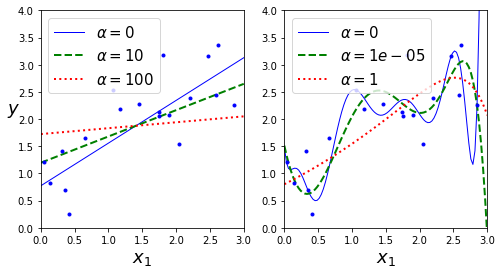

In [24]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()
# 규제가 증가할 수록, 모델의 분산은 줄지만, 편향은 커지게 된다.

### 4.5.2 라쏘 회귀

라쏘 모델 적용

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0627339717781554, tolerance: 0.0016973796073164735
  model = cd_fast.enet_coordinate_descent(


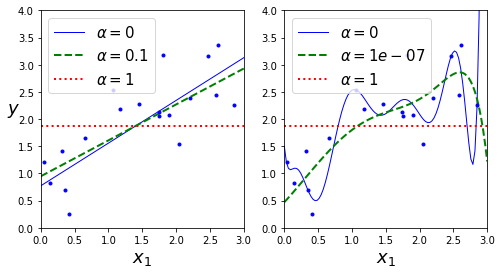

In [25]:

from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

In [26]:
#Lasso클래스를 사용한 간단한 사이킷런 예제
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])
# = SGDRegressor(penalty='l1')

array([1.93928978])

라쏘와 릿지 회귀의 차이점

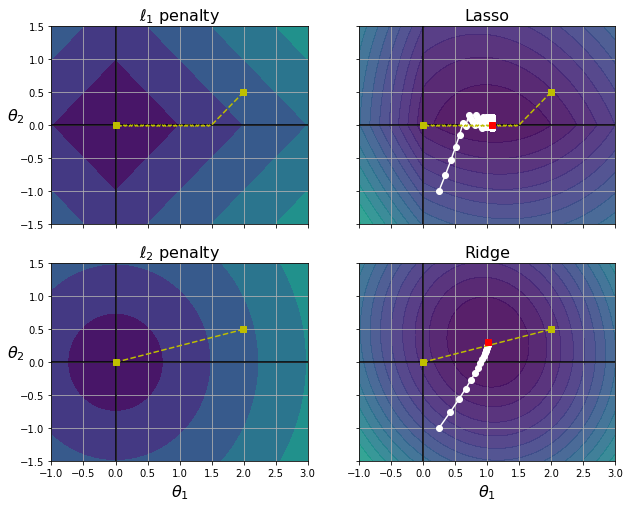

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

### 4.5.3 엘라스틱 넷

엘라스틱넷 사용

In [28]:
#사이킷런의 ElasticNet
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.94117801])

### 4.5.4 조기 종료

데이터 생성

In [29]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(),
                                                  test_size=0.5, random_state=10)

In [30]:
# warm_start = True를 지정하면 fit()가 호출될 때 이전 모델 파라미터에서 훈련을 이어감
from sklearn.base import clone

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)


## 4.6 로지스틱 회귀

### 4.6.3 결정 경계

붓꽃 데이터셋 사용

In [31]:
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']


로지스틱 회귀 모델 훈련

In [32]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률을 계산

C:\Users\user\anaconda3\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


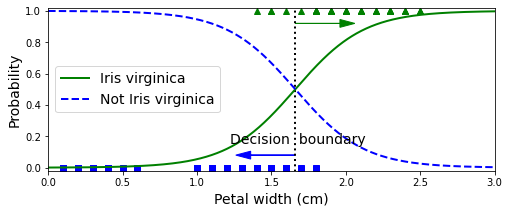

In [33]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

plt.show()

In [34]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

결정 경계 확인

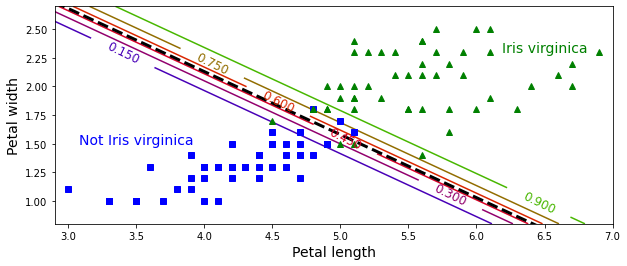

In [35]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

plt.show()

### 4.6.4 소프트맥스 회귀

소프트맥스 회귀를 사용한 붓꽃 분류

In [36]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

#매개변수 multinomial, lbfgs 같이  소프트맥스 회귀를 지원하는 알고리즘 사용
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [37]:
print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]))

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]


결정경계

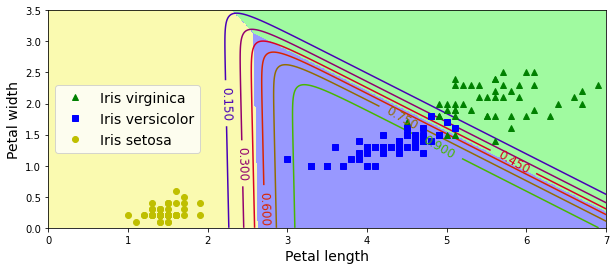

In [38]:
#결정경계
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

plt.show()

# 딥러닝 홀로서기

## Lab1. Linear Regression

### 1. Data Generation
공부한 시간에 따른 성적 데이터 만들기

In [39]:
X = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y = [1, 1, 2, 4, 5, 7, 8, 9, 9, 10]

X, Y데이터를 2D 평면 상에 시각화

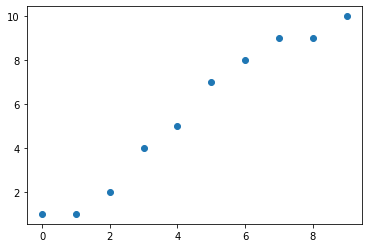

In [40]:
import matplotlib.pyplot as plt
plt.scatter(X, Y)
plt.show()

## 2. Hypothesis Define (Model Define)
Linear Regression 시에 활용하는 f(x) = Wx + b에서 b가 없는 간단한 버전인 f(x) = Wx 라는 모델(가설)을 구현

In [41]:
class H():
  
    def __init__(self, w): 
    # 처음에 모델의 파라미터(학습을 통해 최적화될 값) w를 인풋으로 받아 모델을 만들어줍시다.
        self.w = w
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        return self.w * x
    
h = H(4) # 이제 f(x) = 4x 라는 모델이 만들어졌습니다.
pred_y = h.forward(5) # x=5 라는 인스턴스(샘플)이 인풋으로 들어왔을 때 f(5) = 4 x 5 를 통해서 20 이 정상적으로 출력되는 것을 확인할 수 있습니다.
print('value of f(5) :', pred_y)
print('value of w :', h.w) # 모델 h의 내부 파라미터를 출력했을 때 4가 정상적으로 출력되는 것도 확인할 수 있습니다.

value of f(5) : 20
value of w : 4


## 3. Cost Function Define(Loss Function Define) 

In [42]:
def cost(h, X, Y):
    error = 0
    for i in range(len(X)):
        error += (h.forward(X[i]) - Y[i])**2
    error = error / len(X)
    return error

h = H(4) # 위에서 이미 한번 생성했지만 다시 생성해봅니다.
print('cost value when w = 4 :', cost(h, X, Y)) # f(x) = 4 x 인 현재의 모델은 저희가 관측한 데이터셋에 대해서 222.2 라는 cost를 가지네요 (상당히 크죠?)

def better_cost(pred_y, true_y):
  # 이 코드가 조금 더 나은 버전이라고 할 수 있는데요. 위에 있는 cost(h, X, Y)에서는 cost function 안에서 H(x)를 계산해야 하는 불편함이 있기 때문에
  # 일반적으로 코드를 짤 때 cost function(loss function)들은 모델이 예측한 y 값들의 리스트와 실제 y 값들의 리스트만 받아서 계산하는 구조를 취합니다.
  
    error = 0
    for i in range(len(X)):
        error += (pred_y[i] - true_y[i])**2
    error = error / len(X)
    return error

pred_y = [ h.forward(X[i]) for i in range(len(X)) ] # 미리 모델 h를 통해서 각 x 인스턴스에 대한 y 값을 예측해봅시다. 
print('cost value with better code structure :', better_cost(pred_y, Y)) # 위와 같이 똑같이 222.2 라는 값이 나오는 것을 확인할 수 있죠. 잘 작동하는 군요

cost value when w = 4 : 222.2
cost value with better code structure : 222.2


Cost Surface Visualization

[-10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
[3582.2, 3269.825, 2971.7, 2687.825, 2418.2, 2162.825, 1921.7, 1694.825, 1482.2, 1283.825, 1099.7, 929.825, 774.2, 632.825, 505.7, 392.825, 294.2, 209.825, 139.7, 83.825, 42.2, 14.825, 1.7, 2.825, 18.2, 47.825, 91.7, 149.825, 222.2, 308.825, 409.7, 524.825, 654.2, 797.825, 955.7, 1127.825, 1314.2, 1514.825, 1729.7, 1958.825]


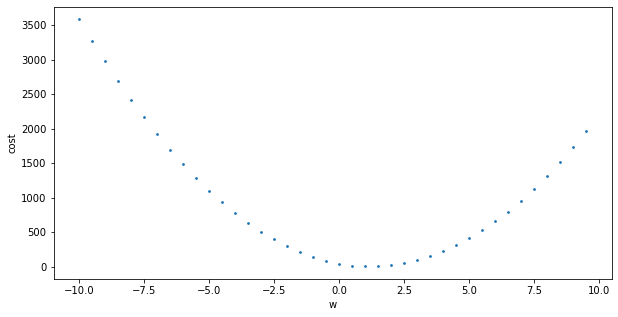

In [43]:
list_w = []
list_c = []
for i in range(-20, 20):
    w = i * 0.5
    h = H(w)
    c = cost(h, X, Y)
    list_w.append(w)
    list_c.append(c)
    
print(list_w) # w 값들이 잘 들어갔는지 확인해봅시다.
print(list_c) # c 값들이 잘 들어갔는지 확인해봅시다.

plt.figure(figsize=(10,5))
plt.xlabel('w')
plt.ylabel('cost')
plt.scatter(list_w, list_c, s=3)

### Gradoent Descent Algorithm

첫 번째 방식 : 수치해석적으로 w=4인 지점과 w=4 + eps 인 지점에서의 cost값을 각각 구한 뒤 두 값의 차이를 통해 그라이디언트를 구하는 방식

두 번째 방식 : cost function을 w로 편미분한 공식을 통해 바로 특정 w에서의 그라디언트를 구하는 방식

1.2105213157896242 0.43684210597565787 1.2105263157894737 0.43684210526315803


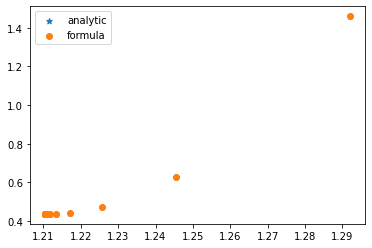

In [44]:
def cal_grad(w, cost): # 수치해석적으로 그라디언트를 근사해봅니다.
    h = H(w)
    cost1 = cost(h, X, Y)
    eps = 0.00001 
    h = H(w+eps) # w에서 epsilon 만큼 떨어진 부분에서도 cost를 구해줍니다.
    cost2 = cost(h, X, Y)
    dcost = cost2 - cost1
    dw = eps
    grad = dcost / dw
    return grad, (cost1+cost2)*0.5

def cal_grad2(w, cost): # 편미분한 공식에 바로 대입하여 그라디언트를 근사해봅니다. 
    h = H(w)
    grad = 0
    for i in range(len(X)):
        grad += 2 * (h.forward(X[i]) - Y[i]) * X[i]
    grad = grad / len(X)
    c = cost(h, X, Y)
    return grad, c


# 두 방식을 이용해서 w = 1.4 라는 지점에서 모델을 각각 초기화한 뒤에 Gradient Descent Algorithm 을 통해 내려갔을 때 거의 같은 결과가 나오는지 확인해봅시다.
w1 = 1.4
w2 = 1.4
lr = 0.01

list_w1 = []
list_c1 = []
list_w2 = []
list_c2 = []

for i in range(100): # 총 100번의 Iteration(반복)을 통해서 학습을 진행해봅시다.
    grad, mean_cost = cal_grad(w1, cost)
    grad2, mean_cost2 = cal_grad2(w2, cost)

    w1 -= lr * grad
    w2 -= lr * grad2
    list_w1.append(w1)
    list_w2.append(w2)
    list_c1.append(mean_cost)
    list_c2.append(mean_cost2)
    
print(w1, mean_cost, w2, mean_cost2) # 100번의 학습이 끝난 뒤에 w1 과 w2 를 출력해보니 둘다 1.21 정도로 비슷한 값으로 수렴한 것을 확인할 수 있습니다.
  
# 매 Iteration에서의 w 값과 cost 값을 그래프 상에 찍어보면 둘이 거의 정확하게 같은 지점을 통과하므로 초록색 동그라미가 파란색 별표를 가리네요
plt.scatter(list_w1, list_c1, label='analytic', marker='*')
plt.scatter(list_w2, list_c2, label='formula')
plt.legend()


Compare Training process of Two Models Initialized from Different w value

1.2105263157894737 0.43684210526315803 1.2105263157894737 0.43684210526315803


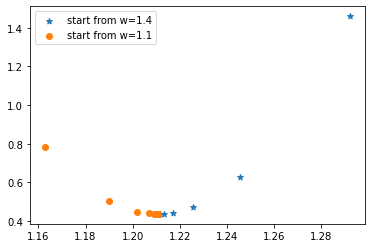

In [45]:
# 편미분 공식을 활용해서 Gradient Descent를 진행하되 서로 다른 w 지점으로 초기화 되었을 때 학습 양상을 확인해봅시다
w1 = 1.4
w2 = 1.1
lr = 0.01

list_w1 = []
list_c1 = []
list_w2 = []
list_c2 = []

for i in range(100): # 총 100번의 Iteration(반복)을 통해서 학습을 진행해봅시다.
    grad, mean_cost = cal_grad2(w1, cost)
    grad2, mean_cost2 = cal_grad2(w2, cost)

    w1 -= lr * grad
    w2 -= lr * grad2
    list_w1.append(w1)
    list_w2.append(w2)
    list_c1.append(mean_cost)
    list_c2.append(mean_cost2)
    
print(w1, mean_cost, w2, mean_cost2) # 100번의 학습이 끝난 뒤에 w1 과 w2 를 출력해보니 둘다 1.21 정도로 비슷한 값으로 수렴한 것을 확인할 수 있습니다.
  
# 서로 다른 지점으로부터 시작하였더라도 학습이 진행됨에 따라 둘 다 같은 파라미터(w=1.21)로 수렴하는 양상을 확인할 수 있습니다.
plt.scatter(list_w1, list_c1, label='start from w=1.4', marker='*')
plt.scatter(list_w2, list_c2, label='start from w=1.1')
plt.legend()

## Lab2. Pytorch_regression

### 1. Data Generation

### 1. Data Generation  (Preparation)

이번에는 X가 2차원 Y가 1차원인 상황입니다.  
아래 관계를 따르는 데이터 분포가 있으며 관측시 발생한 오차가 $e$가 더해져 있다고 합시다.  
$sin(x)$ 함수와 $log(x)$ 함수 모두 쉽게 생각할 수 있는 non-linear 함수이죠!  

$$ e \sim \mathcal{N} (0, 0.5) $$
$$y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  


**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

X, Y 데이터를 3D 공간에 시각화

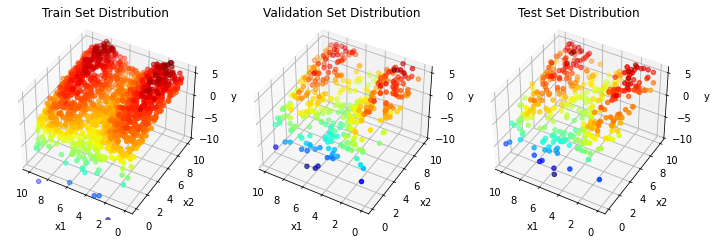

In [46]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# ====== Generating Dataset ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e
# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

### 2. Hypothesis Define (Model Define)

Linear Regression 시에 활용하는 H(x) = Wx + b를 파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어주면 됩니다. 이 때`in_features`는 x의 차원이고, `out_features`는 y의 차원입니다.  


**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

In [47]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True)
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        return self.linear(x)
    
    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

### 3. Cost Function Define(Loss Function Define)

Pytorch의 nn아래에 다양한 Loss Function이 이미 구현되어 있다.

In [48]:
reg_loss = nn.MSELoss()

# """uncomment for testing Loss Function
test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))
# """


tensor(0.5000)
tensor(0.)


### 4. Train & Evaluation

이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다. 

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게됩니다. 
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다. 여기서 Metric으로는 mean absolute error(MAE)를 활용해보죠

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

Parameter containing:
tensor([[-0.4029,  0.3883]], requires_grad=True)
Parameter containing:
tensor([-0.1734], requires_grad=True)
801 parameters


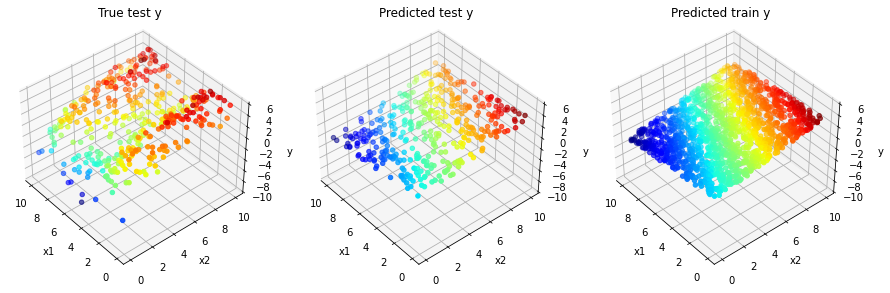

0 tensor(5.5711, grad_fn=<MseLossBackward>)


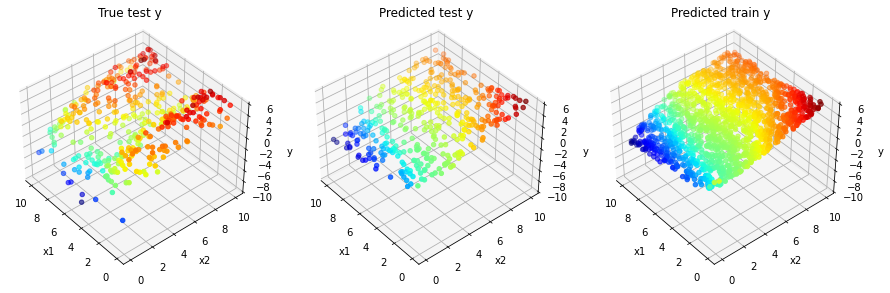

200 tensor(2.1783, grad_fn=<MseLossBackward>)


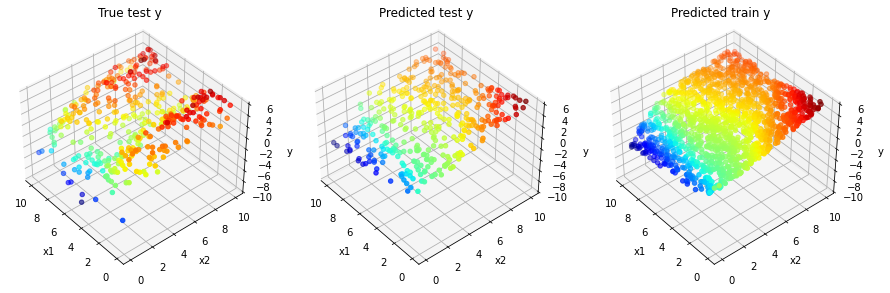

400 tensor(1.9551, grad_fn=<MseLossBackward>)


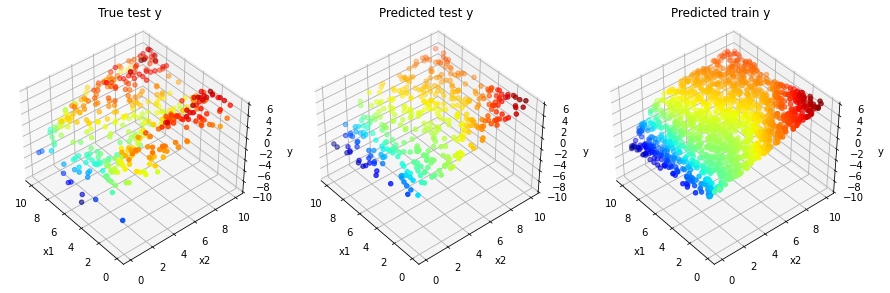

600 tensor(1.8375, grad_fn=<MseLossBackward>)


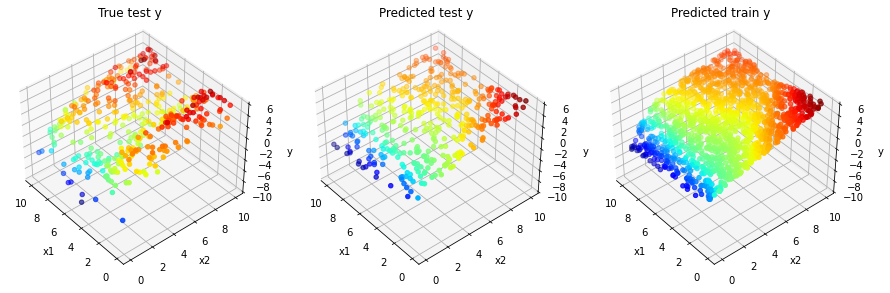

800 tensor(1.7418, grad_fn=<MseLossBackward>)


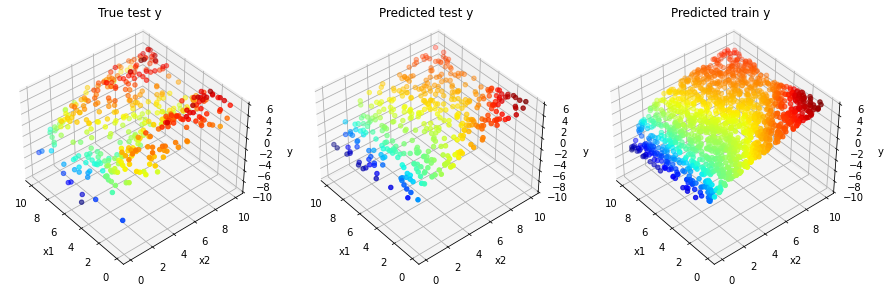

1000 tensor(1.6631, grad_fn=<MseLossBackward>)


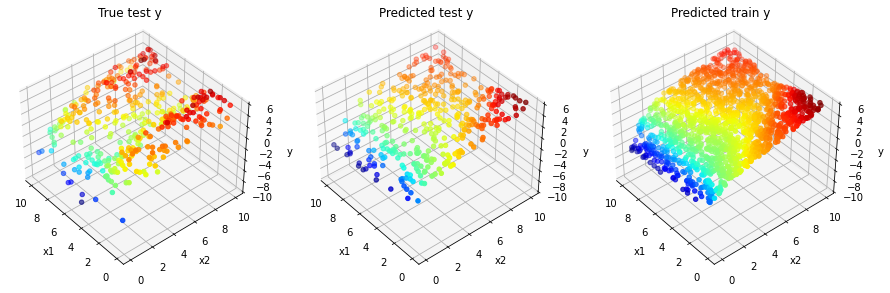

1200 tensor(1.5886, grad_fn=<MseLossBackward>)


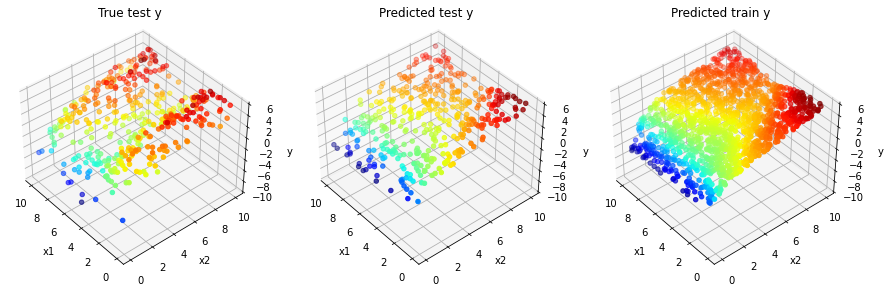

1400 tensor(1.5099, grad_fn=<MseLossBackward>)


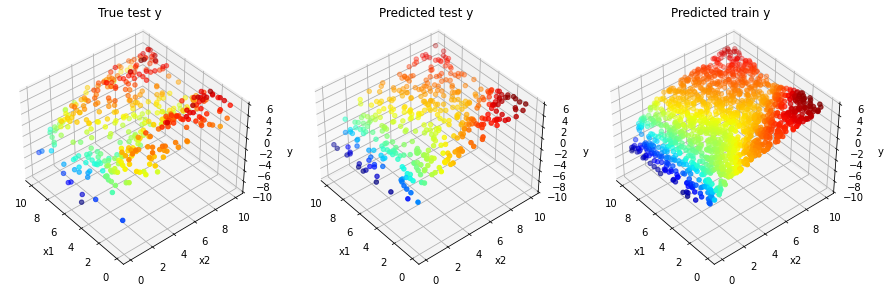

1600 tensor(1.4367, grad_fn=<MseLossBackward>)


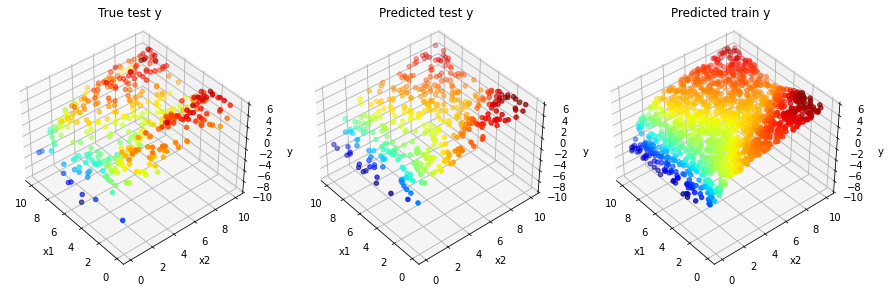

1800 tensor(1.3746, grad_fn=<MseLossBackward>)


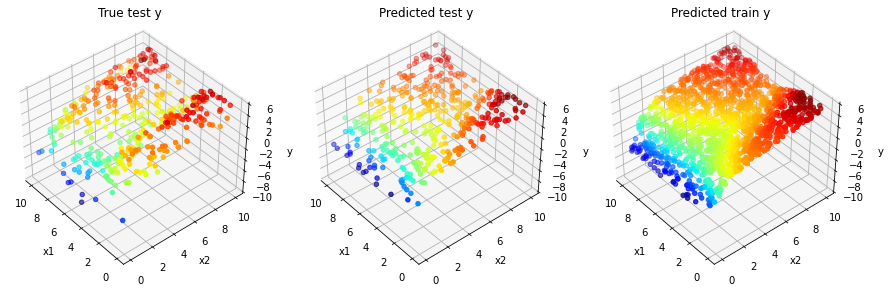

2000 tensor(1.3186, grad_fn=<MseLossBackward>)


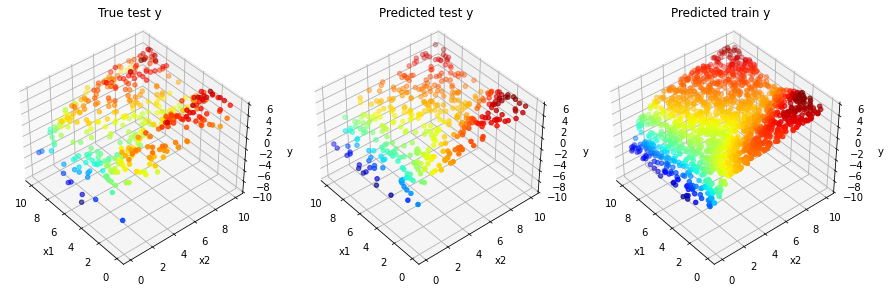

2200 tensor(1.2698, grad_fn=<MseLossBackward>)


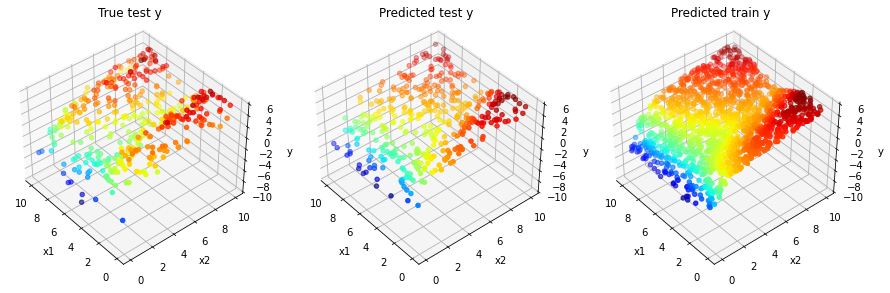

2400 tensor(1.2227, grad_fn=<MseLossBackward>)


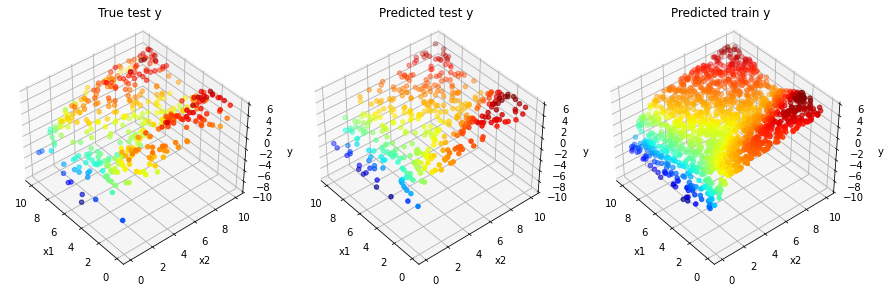

2600 tensor(1.1841, grad_fn=<MseLossBackward>)


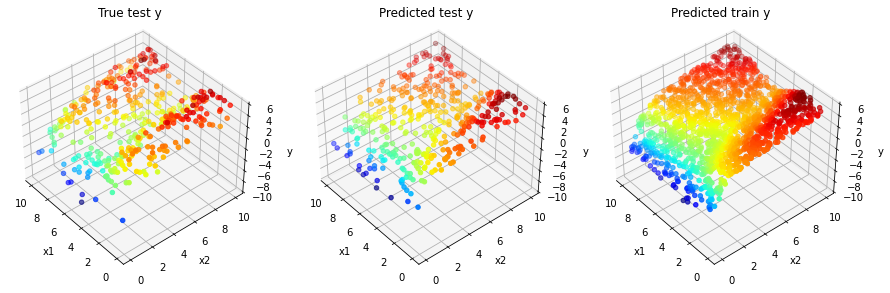

2800 tensor(1.1467, grad_fn=<MseLossBackward>)


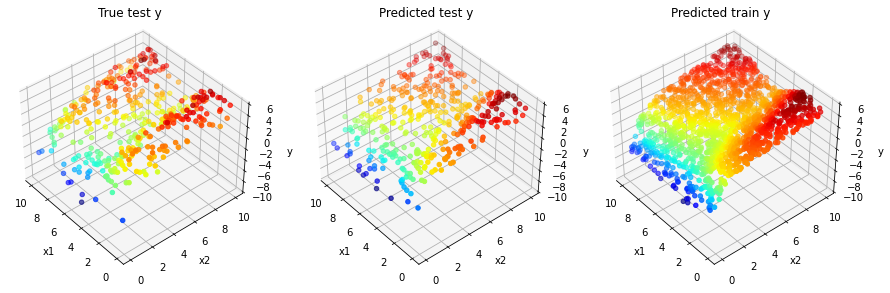

3000 tensor(1.1159, grad_fn=<MseLossBackward>)


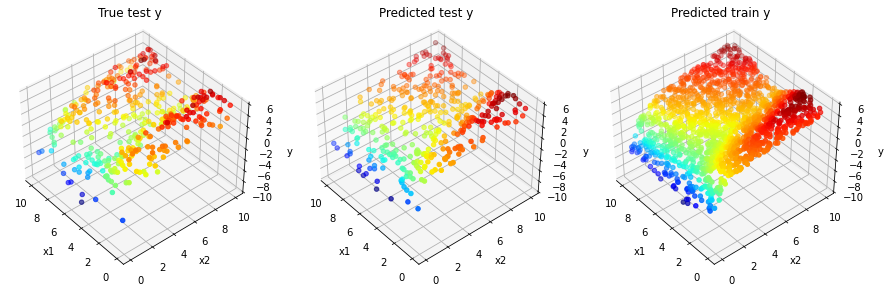

3200 tensor(1.0847, grad_fn=<MseLossBackward>)


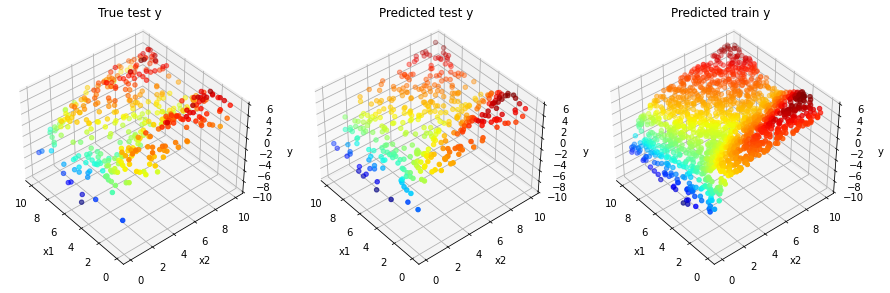

3400 tensor(1.0617, grad_fn=<MseLossBackward>)


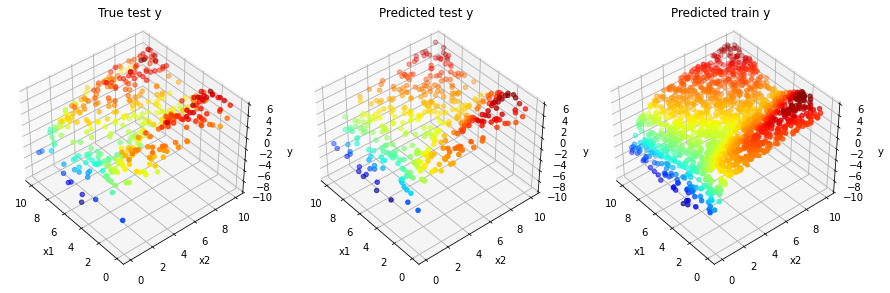

3600 tensor(1.0409, grad_fn=<MseLossBackward>)


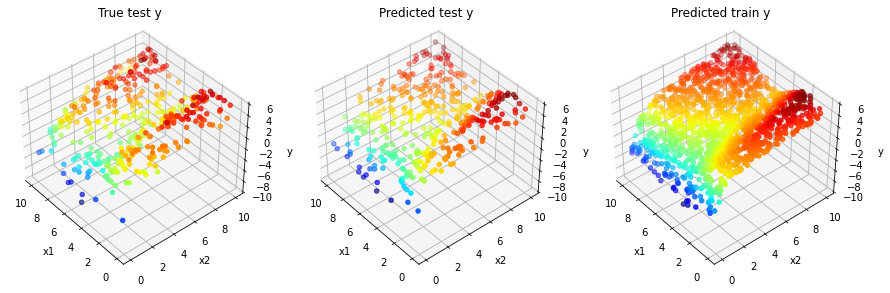

3800 tensor(1.0235, grad_fn=<MseLossBackward>)


In [51]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error


# ====== Construct Model ====== #
model = LinearModel()
print(model.linear.weight)
print(model.linear.bias)

model = MLPModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = reg_loss(pred_y.squeeze(), true_y)
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

### 5. Report Expoeriment

학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

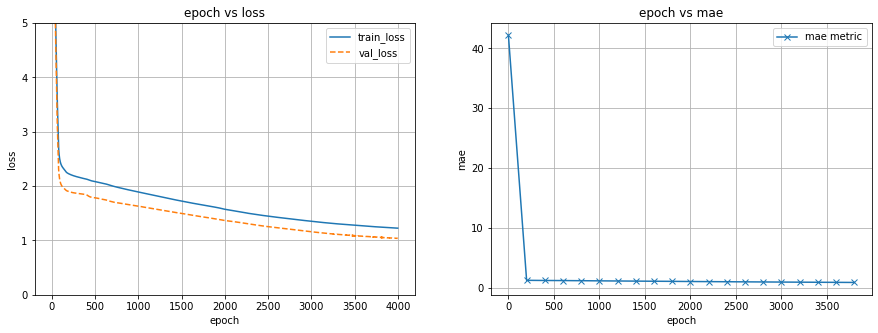

In [50]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()